In [109]:
# # Farm Parcel Analysis Notebook  
# Date: 08/11/2025
# Author:  Judith Bross 

# ## Objectives:  
# 1. Correctly identify farm parcels
# 2. Redo K-means clustering with optimal parameters  

## later
# 3. Create proper Pandas datetime objects for ECOSTRESStime series analysis  



In [ ]:
#### Rename parcels

In [10]:
# Original documents sent by Dr. Foster
original_data_binned = "C:\\Users\\jbros\\OneDrive\\Documents\\SanDiego_FarmParcelAnalysis\\farm_data_binned.csv"
original_data_total = "C:\\Users\\jbros\\OneDrive\\Documents\\SanDiego_FarmParcelAnalysis\\farm_data_total.csv"

# Read the CSV files
import pandas as pd

df_binned = pd.read_csv(original_data_binned)
df_total = pd.read_csv(original_data_total)

# Standardize column names 
df_binned.columns = df_binned.columns.str.lower()
df_total.columns = df_total.columns.str.lower()

# Merge the dataframes by site_id 
merged_df = pd.merge(df_binned, df_total, on='site_id', how='inner')  # adjust merge type as needed

print("Merged DataFrame columns:", merged_df.columns.tolist())

merged_df.head()

Merged DataFrame columns: ['site_id', 'permittee', 'site_name', 'calc_acres', 'z_bin', 'dens', 'mean_height', 'max_height', 'total_trees']


,site_id,permittee,site_name,calc_acres,z_bin,dens,mean_height,max_height,total_trees
0,AWC001,"TREESAP FARMS, LLC dba HINES GROWERS",2500 RAINBOW VALLEY,182.76776,"(0,5]",4,8.675800,13.139984,44
1,AWC001,"TREESAP FARMS, LLC dba HINES GROWERS",2500 RAINBOW VALLEY,182.76776,"(5,10]",23,8.675800,13.139984,44
2,AWC001,"TREESAP FARMS, LLC dba HINES GROWERS",2500 RAINBOW VALLEY,182.76776,"(10,15]",17,8.675800,13.139984,44
3,AWW023,"TREESAP FARMS, LLC dba HINES GROWERS",1930 RAINBOW VALLEY,11.25635,"(0,5]",3,9.582724,16.341583,31
4,AWW023,"TREESAP FARMS, LLC dba HINES GROWERS",1930 RAINBOW VALLEY,11.25635,"(5,10]",14,9.582724,16.341583,31


In [12]:
import pandas as pd
import geopandas as gpd
from pathlib import Path

# Load the agricultural parcels shapefile
shapefile_dir = Path(r"C:\Users\jbros\OneDrive\Documents\SanDiego_RemoteSensing\Agricultural_Commodity_2020_shapefile")
parcels_gdf = gpd.read_file(shapefile_dir / "Agricultural_Commodity_2020.shp")

# Check for duplicate site_ids in the shapefile
duplicate_sites = parcels_gdf['site_id'].value_counts()
duplicate_sites = duplicate_sites[duplicate_sites > 1].index.tolist()

print(f"Found {len(duplicate_sites)} site_ids with multiple polygons")
print(f"Total duplicate polygons: {sum(parcels_gdf['site_id'].isin(duplicate_sites))}")

# Create a copy of the original site_id column before any modifications
parcels_gdf['original_name'] = parcels_gdf['site_id']

# Create a function to rename duplicates
def rename_duplicates(df):
    if len(df) > 1:
        # Add suffix (_A, _B, etc)
        suffixes = [f"_{chr(65+i)}" for i in range(len(df))]
        df['site_id'] = df['original_name'] + suffixes
    return df

# Apply the renaming only to duplicate sites
if len(duplicate_sites) > 0:
    # Create a mask for duplicates
    mask = parcels_gdf['original_name'].isin(duplicate_sites)
    
    # Group by original_name instead of site_id
    grouped = parcels_gdf[mask].groupby('original_name', group_keys=False)
    
    # Apply the renaming
    renamed = grouped.apply(rename_duplicates)
    
    # Update the original dataframe
    parcels_gdf.loc[mask] = renamed
    
    # Verify changes
    print("\nSample of renamed parcels:")
    sample = parcels_gdf[parcels_gdf['original_name'].isin(duplicate_sites)]
    print(sample[['original_name', 'site_id', 'geometry']].head(10))
    
    # Print full list of duplicates
    print("\nComplete list of renamed parcels:")
    for site_id in duplicate_sites:
        count = sum(sample['original_name'] == site_id)
        renamed = sample[sample['original_name'] == site_id]['site_id'].tolist()
        print(f"{site_id}: {count} polygons → {', '.join(renamed)}")
else:
    print("No duplicate site_ids found in the shapefile")



# Verify no duplicates remain
remaining_duplicates = parcels_gdf['site_id'].duplicated().sum()
print(f"Remaining duplicates after processing: {remaining_duplicates}")

Found 429 site_ids with multiple polygons
Total duplicate polygons: 887


C:\Users\jbros\AppData\Local\Temp\ipykernel_6492\220551978.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  renamed = grouped.apply(rename_duplicates)



Sample of renamed parcels:
   original_name   site_id                                           geometry
28        AVQ001  AVQ001_A  POLYGON ((6345662.298 1984098.227, 6346832.829...
29        BKD002  BKD002_A  POLYGON ((6252986.186 2039595.908, 6253429.05 ...
30        BKD003  BKD003_A  POLYGON ((6252463.652 2039872.9, 6252438.89 20...
31        BKD016  BKD016_A  POLYGON ((6256218.888 2040961.993, 6256215.267...
32        BWD006  BWD006_A  POLYGON ((6248668.293 2038521.174, 6249240.223...
33        EAZ015  EAZ015_A  POLYGON ((6247020.943 2041024.606, 6247065.468...
34        ACY226  ACY226_A  POLYGON ((6261256.494 2042864.365, 6261240.036...
35        EAZ012  EAZ012_A  POLYGON ((6247668.019 2039157.093, 6247943.138...
36        EAZ011  EAZ011_A  POLYGON ((6247638.913 2039186.798, 6244817.876...
37        EAZ016  EAZ016_A  POLYGON ((6253654.014 2046373.524, 6253669.27 ...

Complete list of renamed parcels:
01: 8 polygons → 01_A, 01_B, 01_C, 01_D, 01_E, 01_F, 01_G, 01_H
ATC027: 5 polyg

In [14]:
# 1. Rename for clarity
merged_df = merged_df.rename(columns={
    'dens':      'tree_ct',
    'z_bin':     'z_bin_hgtcateg'
})

# 2. Convert acres → hectares 
merged_df['calc_hectares'] = merged_df['calc_acres'] * 0.404

# 3. Density per hectare (total & binned)
merged_df['dens_ha_total']  = merged_df['total_trees'] / merged_df['calc_hectares']
merged_df['dens_ha_binned'] = merged_df['tree_ct']    / merged_df['calc_hectares']

# 4. Percent of trees in each bin
merged_df['binned_percent'] = merged_df['tree_ct']    / merged_df['total_trees']

# 5.  reorder 
cols = [
    'site_id','mean_height','max_height','z_bin_hgtcateg',
    'tree_ct','total_trees','calc_acres','calc_hectares',
    'dens_ha_total','dens_ha_binned','binned_percent'
]
merged_df = merged_df[cols]

# 6. Peek
print(merged_df.head())


  site_id  mean_height  max_height z_bin_hgtcateg  tree_ct  total_trees  \
0  AWC001     8.675800   13.139984          (0,5]        4           44   
1  AWC001     8.675800   13.139984         (5,10]       23           44   
2  AWC001     8.675800   13.139984        (10,15]       17           44   
3  AWW023     9.582724   16.341583          (0,5]        3           31   
4  AWW023     9.582724   16.341583         (5,10]       14           31   

   calc_acres  calc_hectares  dens_ha_total  dens_ha_binned  binned_percent  
0   182.76776      73.838175       0.595898        0.054173        0.090909  
1   182.76776      73.838175       0.595898        0.311492        0.522727  
2   182.76776      73.838175       0.595898        0.230233        0.386364  
3    11.25635       4.547565       6.816834        0.659694        0.096774  
4    11.25635       4.547565       6.816834        3.078570        0.451613  


In [18]:

#  Pivot table: each z_bin_hgtcateg becomes a column
pivot_df = merged_df.pivot_table(
    index='site_id',
    columns='z_bin_hgtcateg',
    values='binned_percent',
    aggfunc='first',   # one value per site_id × bin combination
    fill_value=0       # if no trees in that bin
)

# 3. Sort the bin columns 

def extract_lower_bound(bin_label):
    try:
        return float(bin_label.strip('()[]').split(',')[0])
    except Exception as e:
        print(f"Warning: Could not parse bin label '{bin_label}': {e}")
        return float('inf')  # Push unparseable bins to the end

bins_sorted = sorted(pivot_df.columns, key=extract_lower_bound)
pivot_df = pivot_df[bins_sorted]


pivot_df.head()


z_bin_hgtcateg,"(0,5]","(5,10]","(10,15]","(15,20]","(20,25]","(25,30]","(30,35]","(35,40]"
site_id,,,,,,,,
003,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
006,0.600000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
01,0.265074,0.263936,0.241183,0.200228,0.029579,0.022753,0.005688,0.021615
010,0.375000,0.625000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
014,0.750000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000


In [32]:
# Clean and Filter for K-Means Clustering (with Z-score outlier filter)


import pandas as pd
from scipy.stats import zscore

# 1. Sum of binned percentages per row
row_sums = pivot_df.sum(axis=1)

# 2. Initial "good" sites: row sum between 0.99 and 1.01
good = row_sums.between(0.99, 1.01)
bad_sites = row_sums.index[~good]
print(f" Bad sites removed ({len(bad_sites)}):", bad_sites.tolist())

# 3. Remove bad sites from both datasets
clean_pivot = pivot_df.loc[good]
merged_df = merged_df[~merged_df.site_id.isin(bad_sites)]

# 4. Optional stricter filters
valid_rows = (
    clean_pivot.sum(axis=1).between(0.99, 1.01) &
    (clean_pivot.sum(axis=1) > 0) &
    (~clean_pivot.isnull().any(axis=1))
)
final_df = clean_pivot[valid_rows]

# 5. Apply z-score based outlier filter
z_scores = final_df.apply(zscore)  # column-wise z-scores
non_outliers = (z_scores.abs() < 3).all(axis=1)
cluster_df = final_df[non_outliers]  # final input for K-means

# 6. Final sanity checks
final_sums = cluster_df.sum(axis=1)
print(" Final row-sum range:", round(final_sums.min(), 4), "–", round(final_sums.max(), 4))
print("Count outside [0.99,1.01]:", (~final_sums.between(0.99, 1.01)).sum())
print(" Number of valid (cluster-safe) sites:", cluster_df.shape[0])


 Bad sites removed (16): ['01', 'AAL004', 'AFI001', 'ATW010', 'AUQ001', 'AWE449', 'AWZ132', 'BTY008', 'BVE093', 'CFA020', 'CFD001', 'CFH056', 'CFI005', 'CFY208', 'CHY004', 'EAZ007']
 Final row-sum range: 0.9944 – 1.0003
Count outside [0.99,1.01]: 0
 Number of valid (cluster-safe) sites: 1477


C:\Users\jbros\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\jbros\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\jbros\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\jbros\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

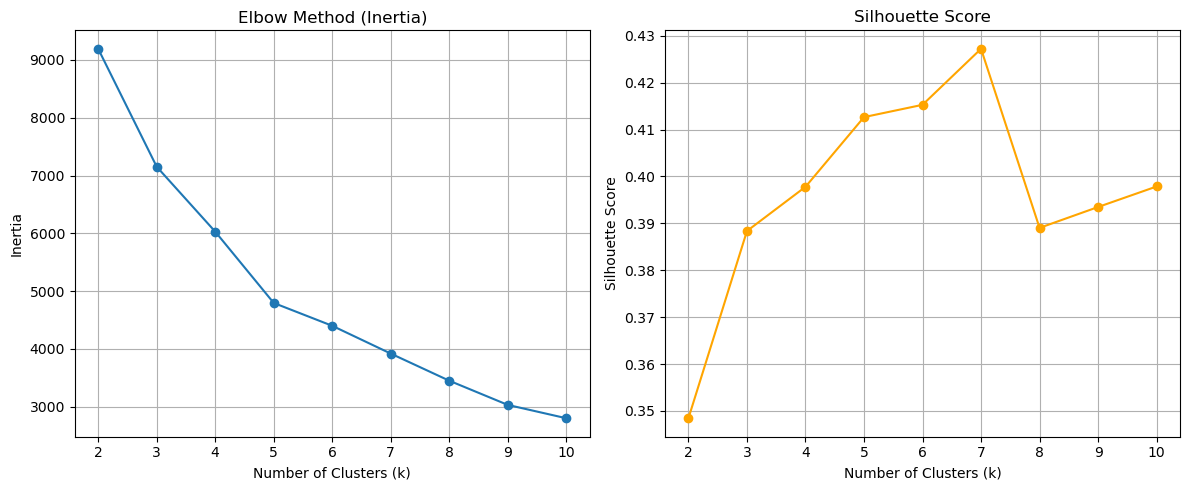

In [34]:
### K-means tests
# === K-Means Elbow and Silhouette Score Tests ===
# Author: Judith Bross
# Date: 08/11/2025

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 1. Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_df)

# 2. Initialize lists to store results
inertias = []
silhouette_scores = []
k_range = range(2, 11)  # trying 2 to 10 clusters

# 3. Loop over k values
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# 4. Plot elbow curve (inertia)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, marker='o')
plt.title('Elbow Method (Inertia)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)

# 5. Plot silhouette score
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()


In [40]:
#K=4

from sklearn.cluster import KMeans

# 1. Re-standardize (in case anything changed)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_df)

# 2. Fit KMeans with k=4
kmeans_final = KMeans(n_clusters=4, random_state=42, n_init='auto')
cluster_labels = kmeans_final.fit_predict(X_scaled)

# 3. Add cluster labels to the cleaned DataFrame
cluster_df['cluster'] = cluster_labels

# 4. Merge cluster labels back into merged_df using site_id
clustered_df = merged_df.copy()
clustered_df = clustered_df.merge(
    cluster_df['cluster'], 
    left_on='site_id', 
    right_index=True, 
    how='inner'
)

# 5. Preview output
print(" Cluster counts:\n", cluster_df['cluster'].value_counts().sort_index())
clustered_df.head()


✅ Cluster counts:
 cluster
0    644
1    515
2     62
3    256
Name: count, dtype: int64


C:\Users\jbros\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\jbros\AppData\Local\Temp\ipykernel_6492\3816924789.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['cluster'] = cluster_labels


,site_id,mean_height,max_height,z_bin_hgtcateg,tree_ct,total_trees,calc_acres,calc_hectares,dens_ha_total,dens_ha_binned,binned_percent,cluster
0,AWC001,8.675800,13.139984,"(0,5]",4,44,182.76776,73.838175,0.595898,0.054173,0.090909,3
1,AWC001,8.675800,13.139984,"(5,10]",23,44,182.76776,73.838175,0.595898,0.311492,0.522727,3
2,AWC001,8.675800,13.139984,"(10,15]",17,44,182.76776,73.838175,0.595898,0.230233,0.386364,3
3,AWW023,9.582724,16.341583,"(0,5]",3,31,11.25635,4.547565,6.816834,0.659694,0.096774,3
4,AWW023,9.582724,16.341583,"(5,10]",14,31,11.25635,4.547565,6.816834,3.078570,0.451613,3


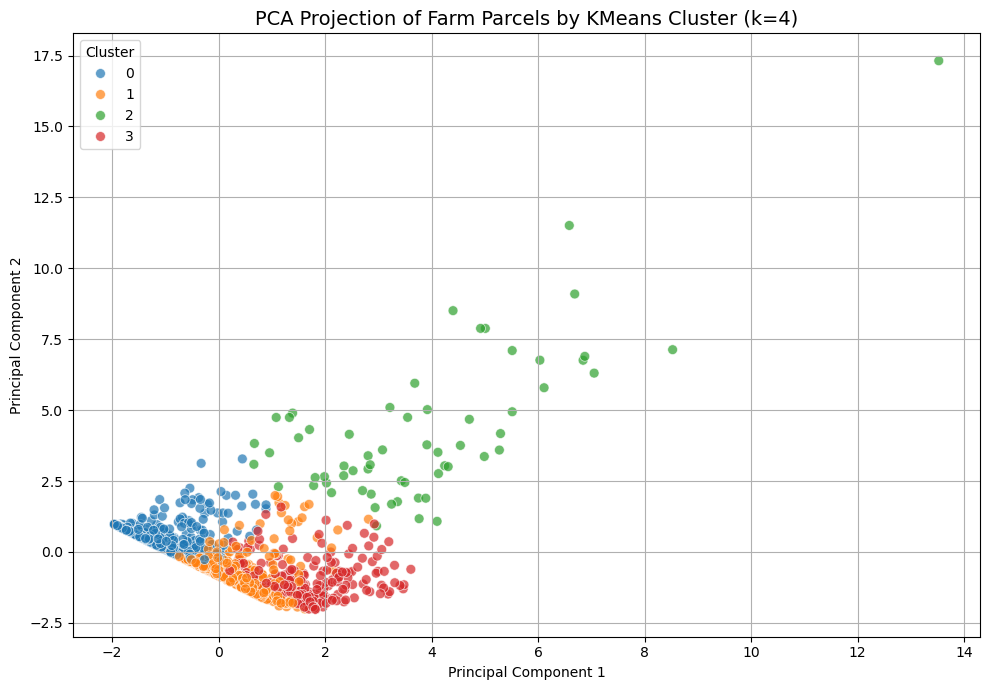

In [44]:
# Visualize Farm Parcels by KMeans Cluster

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Separate features from cluster label
features = cluster_df.drop(columns='cluster')
labels = cluster_df['cluster']

# 2. Scale features again for PCA (
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# 3. Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 4. Build a DataFrame for plotting
pca_df = pd.DataFrame({
    'PCA1': X_pca[:, 0],
    'PCA2': X_pca[:, 1],
    'cluster': labels
})

# 5. Plot with seaborn
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=pca_df,
    x='PCA1', y='PCA2',
    hue='cluster',
    palette='tab10',  # 10-color scheme
    s=50,
    alpha=0.7
)

plt.title('PCA Projection of Farm Parcels by KMeans Cluster (k=4)', fontsize=14)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


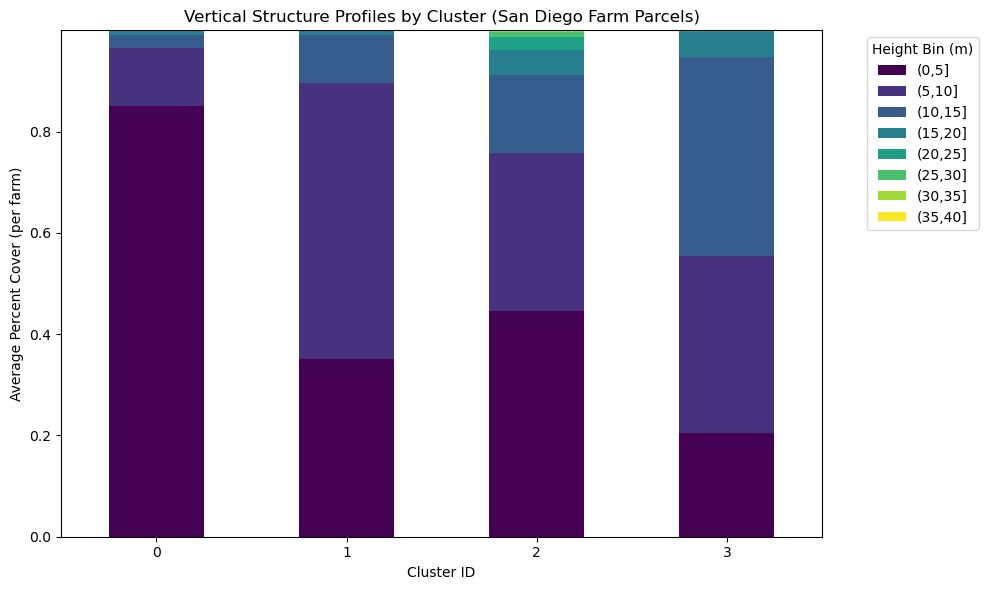

In [46]:
# Visualize Average Tree Height Structure per Cluster (Stacked Bar)

import matplotlib.pyplot as plt

# 1. Extract height bin columns (exclude 'cluster' column)
height_bins = [col for col in cluster_df.columns if col != 'cluster']

# 2. Compute average percent in each height bin per cluster
cluster_profiles = cluster_df.groupby('cluster')[height_bins].mean()

# 3. Optional: sort clusters by profile shape (or keep numeric)
cluster_profiles = cluster_profiles.sort_index()

# 4. Plot stacked bar chart
ax = cluster_profiles.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    colormap='viridis'
)

# 5. Final formatting
plt.ylabel("Average Percent Cover (per farm)")
plt.xlabel("Cluster ID")
plt.title("Vertical Structure Profiles by Cluster (San Diego Farm Parcels)")
plt.xticks(rotation=0)
plt.legend(
    title="Height Bin (m)", 
    bbox_to_anchor=(1.05, 1), 
    loc='upper left'
)
plt.tight_layout()
plt.show()


In [ ]:
#####  Implementing Isla’s Feedback: Canopy Height & Temperature Variability


In [7]:
# STEP 0 — Load the clean farm dataframe
import pandas as pd
from pathlib import Path

# adjust path if needed; this matches what your notebook already uses
clean_path = Path(r"C:\Users\jbros\OneDrive\Documents\SanDiego_FarmParcelAnalysis\farm_data_total.csv")

farm_df = pd.read_csv(clean_path)

print("rows:", len(farm_df), "| cols:", len(farm_df.columns))
farm_df.head(3)

list(farm_df.columns)



rows: 2040 | cols: 4


['SITE_ID', 'mean_height', 'max_height', 'total_trees']

In [9]:
# STEP 1 — Standardize canopy metric and create bins
farm_df = farm_df.copy()

# Standardize column name for clarity
farm_df['avg_canopy_height_m'] = farm_df['mean_height']

# Create quartile bins of average canopy height
farm_df['height_bin_q'] = pd.qcut(
    farm_df['avg_canopy_height_m'],
    q=4,
    duplicates='drop'
)

farm_df[['SITE_ID','avg_canopy_height_m','height_bin_q']].head(10)


,SITE_ID,avg_canopy_height_m,height_bin_q
0,AWC001,8.675800,"(7.541, 19.32]"
1,AWW023,9.582724,"(7.541, 19.32]"
2,AWY277,6.089976,"(5.449, 7.541]"
3,BXN009,6.181155,"(5.449, 7.541]"
4,AWY288,5.139228,"(3.814, 5.449]"
5,CFE122,5.019912,"(3.814, 5.449]"
6,CFH056,7.107260,"(5.449, 7.541]"
7,CFD011,6.890116,"(5.449, 7.541]"
8,CFD028,8.600976,"(7.541, 19.32]"
9,CFJ127,6.275806,"(5.449, 7.541]"


C:\Users\jbros\AppData\Local\Temp\ipykernel_4628\3436404813.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for label, sub in farm_df.groupby('height_bin_q'):


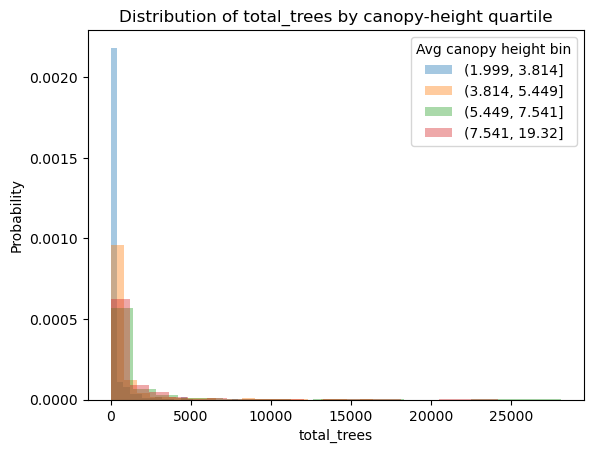

In [11]:
# STEP 2 — Compare distributions across canopy bins
import matplotlib.pyplot as plt

#  replace with any variable(s) you have in farm_df (e.g., NDVI, LST, yield, etc.)
vars_to_plot = ['total_trees']  

for v in vars_to_plot:
    plt.figure()
    for label, sub in farm_df.groupby('height_bin_q'):
        sub[v].plot(kind='hist', density=True, alpha=0.4, label=str(label), bins=20)
    plt.xlabel(v)
    plt.ylabel('Probability')
    plt.title(f'Distribution of {v} by canopy-height quartile')
    plt.legend(title='Avg canopy height bin')
    plt.show()



In [13]:
# STEP 3 — Load daily LST zonal stats and clean
import pandas as pd

lst_path = r"E:\San_LST_ESI_20182025_LOCALTIME\LST\LST_zonal_summary.csv"

lst_df = pd.read_csv(lst_path)

print("raw columns:", lst_df.columns.tolist())
print(lst_df.head(3))


raw columns: ['site_id', 'raster_file', 'datetime', 'mean_C', 'median_C', 'std_C', 'percentile_10_C', 'percentile_90_C']
  site_id                  raster_file             datetime     mean_C  \
0  AWC001  2018.07.13.23.43.42_LST.tif  2018-07-13 23:43:42  21.258656   
1  BPZ008  2018.07.13.23.43.42_LST.tif  2018-07-13 23:43:42  20.396667   
2  AWZ248  2018.07.13.23.43.42_LST.tif  2018-07-13 23:43:42  20.428001   

   median_C     std_C  percentile_10_C  percentile_90_C  
0     21.21  0.471390           20.730           21.910  
1     20.43  0.047141           20.350           20.430  
2     20.35  0.237225           20.226           20.772  


In [17]:
# STEP 4 (fixed) — Aggregate LST variability per farm

# ensure datetime is parsed
lst_df['datetime'] = pd.to_datetime(lst_df['datetime'], errors='coerce')

# make sure IDs are same type / same case
farm_df['SITE_ID'] = farm_df['SITE_ID'].astype(str)
lst_df['site_id']  = lst_df['site_id'].astype(str)

# aggregate variability
lst_var = (
    lst_df.groupby('site_id')
          .agg(sd_meanC=('mean_C','std'),
               mean_of_means=('mean_C','mean'),
               n_obs=('mean_C','count'))
          .reset_index()
)

print(lst_var.head(5))

# merge with canopy dataframe
merged = farm_df.merge(lst_var, left_on='SITE_ID', right_on='site_id', how='inner')
print(merged[['SITE_ID','avg_canopy_height_m','sd_meanC','mean_of_means']].head(10))



  site_id   sd_meanC  mean_of_means  n_obs
0     001  10.726475      17.808024    992
1     002  11.416864      18.800474    507
2     003  10.908335      17.800442    481
3     004  11.088895      17.952692    473
4     005  11.405534      18.294399    480
  SITE_ID  avg_canopy_height_m   sd_meanC  mean_of_means
0  AWC001             8.675800  11.050948      17.771360
1  AWW023             9.582724  11.961346      18.734744
2  AWY277             6.089976  11.966073      18.405139
3  BXN009             6.181155  11.970179      18.071902
4  AWY288             5.139228  12.534827      18.334038
5  CFE122             5.019912  12.394788      18.000360
6  CFH056             7.107260  12.752499      18.286559
7  CFD011             6.890116  13.033676      18.025622
8  CFD028             8.600976  11.523745      17.193945
9  CFJ127             6.275806  11.882097      17.554830


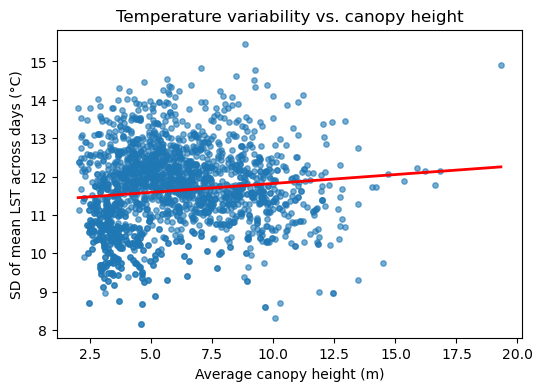

Trend slope: 0.046 °C per meter canopy height


In [19]:
# STEP 6 — Scatter plot: LST variability vs avg canopy height
import matplotlib.pyplot as plt
import numpy as np

x = merged['avg_canopy_height_m']
y = merged['sd_meanC']

# linear fit for trend
mask = x.notna() & y.notna()
m, b = np.polyfit(x[mask], y[mask], 1)

plt.figure(figsize=(6,4))
plt.scatter(x, y, s=15, alpha=0.6)
plt.plot(np.sort(x[mask]), m*np.sort(x[mask]) + b, color="red", lw=2)

plt.xlabel("Average canopy height (m)")
plt.ylabel("SD of mean LST across days (°C)")
plt.title("Temperature variability vs. canopy height")
plt.show()

print(f"Trend slope: {m:.3f} °C per meter canopy height")


In [21]:
# STEP 7 — Correlation & significance
from scipy.stats import linregress, pearsonr

x = merged['avg_canopy_height_m']
y = merged['sd_meanC']
mask = x.notna() & y.notna()

# Pearson correlation
r, p = pearsonr(x[mask], y[mask])
print(f"Pearson r = {r:.3f}, p = {p:.3g}")

# Linear regression details
slope, intercept, r_value, p_value, std_err = linregress(x[mask], y[mask])
print(f"LinReg slope = {slope:.3f}, p = {p_value:.3g}, R² = {r_value**2:.3f}")


Pearson r = 0.109, p = 9.69e-07
LinReg slope = 0.046, p = 9.69e-07, R² = 0.012


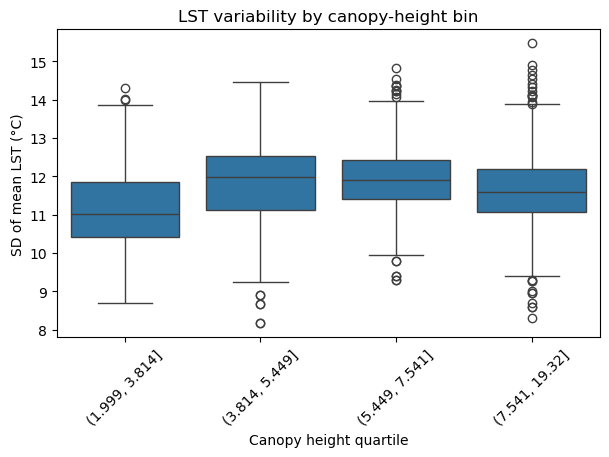

ANOVA F = 54.50, p = 7.38e-34


C:\Users\jbros\AppData\Local\Temp\ipykernel_4628\1028409331.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [g["sd_meanC"].dropna().values for _, g in merged_bins.groupby("height_bin_q")]


In [23]:
# STEP 8 — ANOVA across canopy-height quartiles
from scipy.stats import f_oneway
import seaborn as sns
import matplotlib.pyplot as plt

# merge bins into variability table
merged_bins = merged.copy()

# plot distributions by bin
plt.figure(figsize=(7,4))
sns.boxplot(data=merged_bins, x="height_bin_q", y="sd_meanC")
plt.xlabel("Canopy height quartile")
plt.ylabel("SD of mean LST (°C)")
plt.title("LST variability by canopy-height bin")
plt.xticks(rotation=45)
plt.show()

# run one-way ANOVA
groups = [g["sd_meanC"].dropna().values for _, g in merged_bins.groupby("height_bin_q")]
F, p = f_oneway(*groups)
print(f"ANOVA F = {F:.2f}, p = {p:.3g}")


C:\Users\jbros\AppData\Local\Temp\ipykernel_4628\4237392676.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for label, sub in merged.groupby('height_bin_q'):


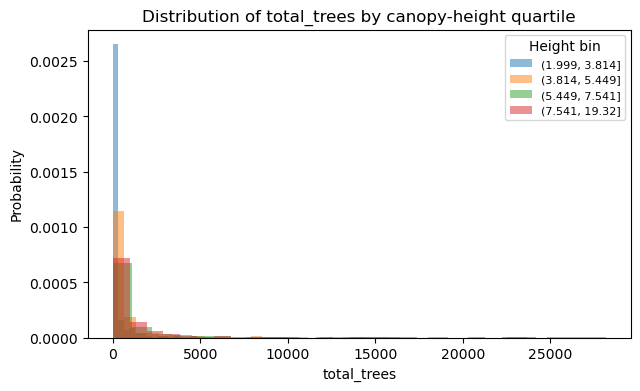

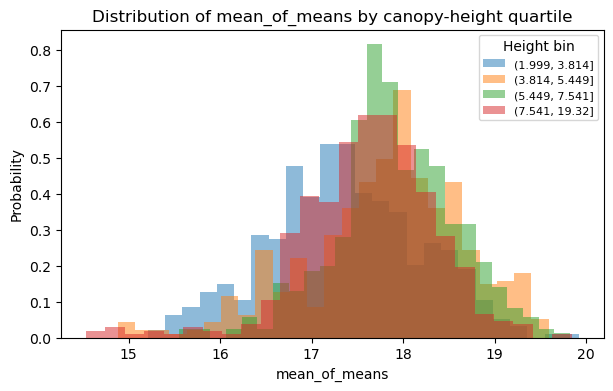

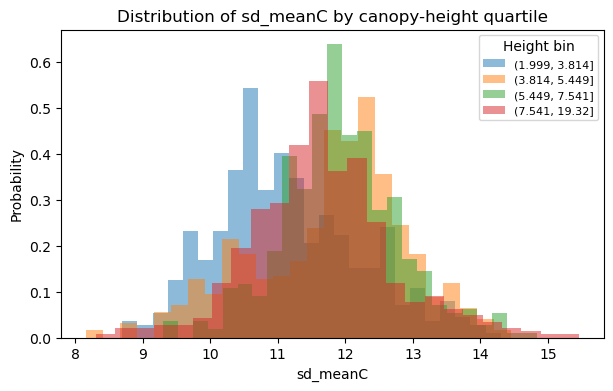

In [27]:
# STEP 10 — Histograms of variables by canopy-height bins
import matplotlib.pyplot as plt

# choose variables you want to explore
vars_to_plot = ['total_trees', 'mean_of_means', 'sd_meanC']

for v in vars_to_plot:
    plt.figure(figsize=(7,4))
    for label, sub in merged.groupby('height_bin_q'):
        plt.hist(
            sub[v].dropna(),
            bins=25,
            alpha=0.5,
            label=f"{label}",
            density=True
        )
    plt.xlabel(v)
    plt.ylabel("Probability")
    plt.title(f"Distribution of {v} by canopy-height quartile")
    plt.legend(title="Height bin", fontsize=8)
    plt.show()


In [33]:
# STEP 11 — Load and prep ESI zonal stats
import pandas as pd

esi_path = r"E:\San_LST_ESI_20182025_LOCALTIME\ESI\ESI_zonal_summary.csv"
esi_df = pd.read_csv(esi_path)

print("raw columns:", esi_df.columns.tolist())
print(esi_df.head(3))

# 1) parse datetime
esi_df['datetime'] = pd.to_datetime(esi_df['datetime'], errors='coerce')

# 2) align site IDs with farm_df (upper vs lower case)
farm_df['SITE_ID'] = farm_df['SITE_ID'].astype(str)
esi_df['site_id']  = esi_df['site_id'].astype(str)

# 3) filter to only cleaned polygons in farm_df
esi_df = esi_df[esi_df['site_id'].isin(farm_df['SITE_ID'])]

print("rows after cleaning:", len(esi_df))

# Peek columns + first few rows of the ESI dataframe
print("Columns in ESI file:", esi_df.columns.tolist())
print(esi_df.head(3))


raw columns: ['site_id', 'raster_file', 'datetime', 'mean_ESI', 'median_ESI', 'std_ESI', 'percentile_10_ESI', 'percentile_90_ESI']
  site_id                      raster_file             datetime  mean_ESI  \
0  AWC001  2018.07.15.06.59.20_ESI_L4T.tif  2018-07-15 06:59:20  0.338177   
1  AWC002  2018.07.15.06.59.20_ESI_L4T.tif  2018-07-15 06:59:20  0.318532   
2  AWH100  2018.07.15.06.59.20_ESI_L4T.tif  2018-07-15 06:59:20  0.348872   

   median_ESI   std_ESI  percentile_10_ESI  percentile_90_ESI  
0    0.326634  0.080577           0.257421           0.435332  
1    0.303490  0.058274           0.258432           0.387636  
2    0.335155  0.064450           0.260128           0.440670  
rows after cleaning: 164909
Columns in ESI file: ['site_id', 'raster_file', 'datetime', 'mean_ESI', 'median_ESI', 'std_ESI', 'percentile_10_ESI', 'percentile_90_ESI']
  site_id                      raster_file            datetime  mean_ESI  \
0  AWC001  2018.07.15.06.59.20_ESI_L4T.tif 2018-07-15 06:59:2

In [35]:

# Per-farm ESI summary across dates
esi_var = (
    esi_df.groupby('site_id')
          .agg(sd_ESI=('mean_ESI','std'),
               mean_ESI=('mean_ESI','mean'),
               n_obs=('mean_ESI','count'))
          .reset_index()
)
esi_var.head()


,site_id,sd_ESI,mean_ESI,n_obs
0,003,0.130159,0.469389,62
1,006,0.168336,0.410181,62
2,01,0.222971,0.500860,671
3,010,0.121546,0.506529,59
4,011,0.133791,0.423756,61


In [37]:
# Join to canopy table; keeps your existing height_bin_q and avg_canopy_height_m
merged_esi = farm_df.merge(esi_var, left_on='SITE_ID', right_on='site_id', how='inner')
merged_esi[['SITE_ID','avg_canopy_height_m','height_bin_q','mean_ESI','sd_ESI']].head()


,SITE_ID,avg_canopy_height_m,height_bin_q,mean_ESI,sd_ESI
0,AWC001,8.675800,"(7.541, 19.32]",0.554873,0.152891
1,AWW023,9.582724,"(7.541, 19.32]",0.437326,0.187031
2,AWY277,6.089976,"(5.449, 7.541]",0.484857,0.126227
3,BXN009,6.181155,"(5.449, 7.541]",0.528555,0.152080
4,AWY288,5.139228,"(3.814, 5.449]",0.489941,0.142551


C:\Users\jbros\AppData\Local\Temp\ipykernel_4628\3853910507.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for label, sub in merged_esi.groupby('height_bin_q'):


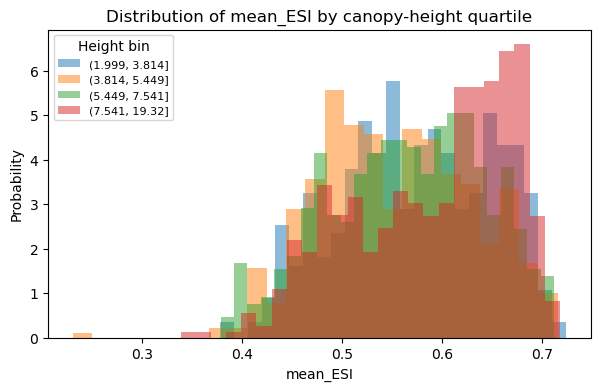

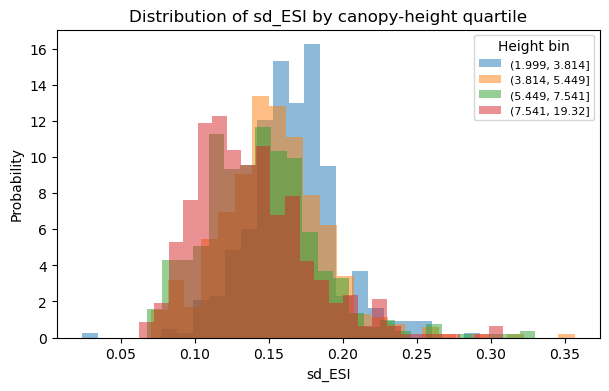

In [39]:
import matplotlib.pyplot as plt

for v in ['mean_ESI', 'sd_ESI']:
    plt.figure(figsize=(7,4))
    for label, sub in merged_esi.groupby('height_bin_q'):
        plt.hist(sub[v].dropna(), bins=25, alpha=0.5, density=True, label=str(label))
    plt.xlabel(v)
    plt.ylabel("Probability")
    plt.title(f"Distribution of {v} by canopy-height quartile")
    plt.legend(title="Height bin", fontsize=8)
    plt.show()


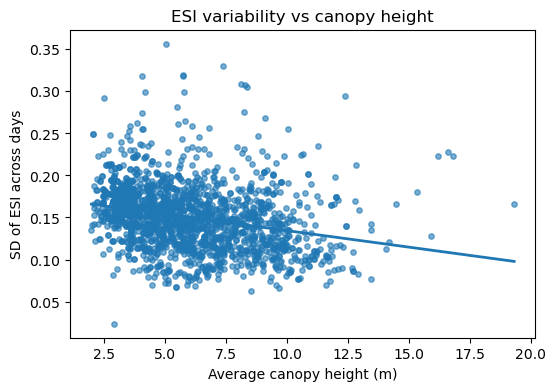

Pearson r = -0.260, p = 1.24e-29
LinReg slope = -0.004, p = 1.24e-29, R² = 0.067


In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, linregress

x = merged_esi['avg_canopy_height_m']
y = merged_esi['sd_ESI']
mask = x.notna() & y.notna()

# Scatter + trend
m, b = np.polyfit(x[mask], y[mask], 1)

plt.figure(figsize=(6,4))
plt.scatter(x, y, s=15, alpha=0.6)
xs = np.linspace(x[mask].min(), x[mask].max(), 200)
plt.plot(xs, m*xs + b, lw=2)
plt.xlabel("Average canopy height (m)")
plt.ylabel("SD of ESI across days")
plt.title("ESI variability vs canopy height")
plt.show()

# Stats
r, p = pearsonr(x[mask], y[mask])
slope, intercept, r_value, p_value, std_err = linregress(x[mask], y[mask])
print(f"Pearson r = {r:.3f}, p = {p:.3g}")
print(f"LinReg slope = {slope:.3f}, p = {p_value:.3g}, R² = {r_value**2:.3f}")


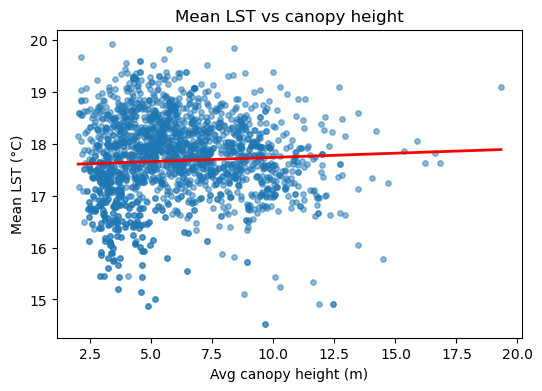

Mean LST vs canopy height: slope=0.016, R²=0.003, p=2.32e-02, r=0.051


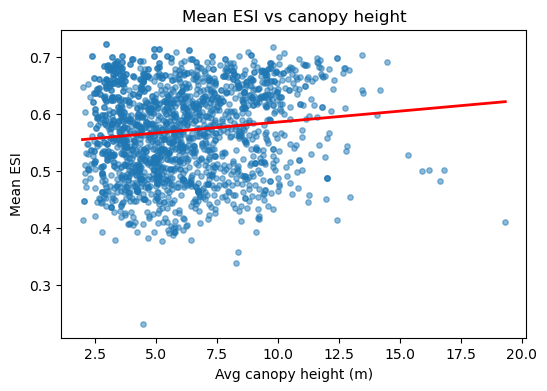

Mean ESI vs canopy height: slope=0.004, R²=0.015, p=1.10e-07, r=0.124


In [45]:
# STEP A — mean value trends vs canopy height
import matplotlib.pyplot as plt
from scipy.stats import linregress, pearsonr
import numpy as np

def plot_trend(df, xcol, ycol, xlabel, ylabel, title):
    x = df[xcol]
    y = df[ycol]
    mask = x.notna() & y.notna()
    slope, intercept, r_value, p_value, std_err = linregress(x[mask], y[mask])
    r, p = pearsonr(x[mask], y[mask])

    plt.figure(figsize=(6,4))
    plt.scatter(x, y, s=15, alpha=0.5)
    xs = np.linspace(x[mask].min(), x[mask].max(), 200)
    plt.plot(xs, slope*xs + intercept, color="red", lw=2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

    print(f"{title}: slope={slope:.3f}, R²={r_value**2:.3f}, p={p_value:.2e}, r={r:.3f}")

# Check mean values
plot_trend(merged,     "avg_canopy_height_m", "mean_of_means",
           "Avg canopy height (m)", "Mean LST (°C)", "Mean LST vs canopy height")

plot_trend(merged_esi, "avg_canopy_height_m", "mean_ESI",
           "Avg canopy height (m)", "Mean ESI", "Mean ESI vs canopy height")


In [47]:
# STEP S1 — assign seasons
def month_to_season(month):
    if month in [12,1,2]:
        return "DJF"  # winter
    elif month in [3,4,5]:
        return "MAM"  # spring
    elif month in [6,7,8]:
        return "JJA"  # summer
    else:
        return "SON"  # fall

# add season column to both dfs
lst_df['season'] = lst_df['datetime'].dt.month.apply(month_to_season)
esi_df['season'] = esi_df['datetime'].dt.month.apply(month_to_season)

# STEP S2 — re-aggregate by season and site
lst_season = (
    lst_df.groupby(['site_id','season'])
          .agg(sd_meanC=('mean_C','std'),
               mean_LST=('mean_C','mean'),
               n_obs=('mean_C','count'))
          .reset_index()
)

esi_season = (
    esi_df.groupby(['site_id','season'])
          .agg(sd_ESI=('mean_ESI','std'),
               mean_ESI=('mean_ESI','mean'),
               n_obs=('mean_ESI','count'))
          .reset_index()
)

# STEP S3 — merge with canopy info
lst_season = farm_df.merge(lst_season, left_on="SITE_ID", right_on="site_id", how="inner")
esi_season = farm_df.merge(esi_season, left_on="SITE_ID", right_on="site_id", how="inner")


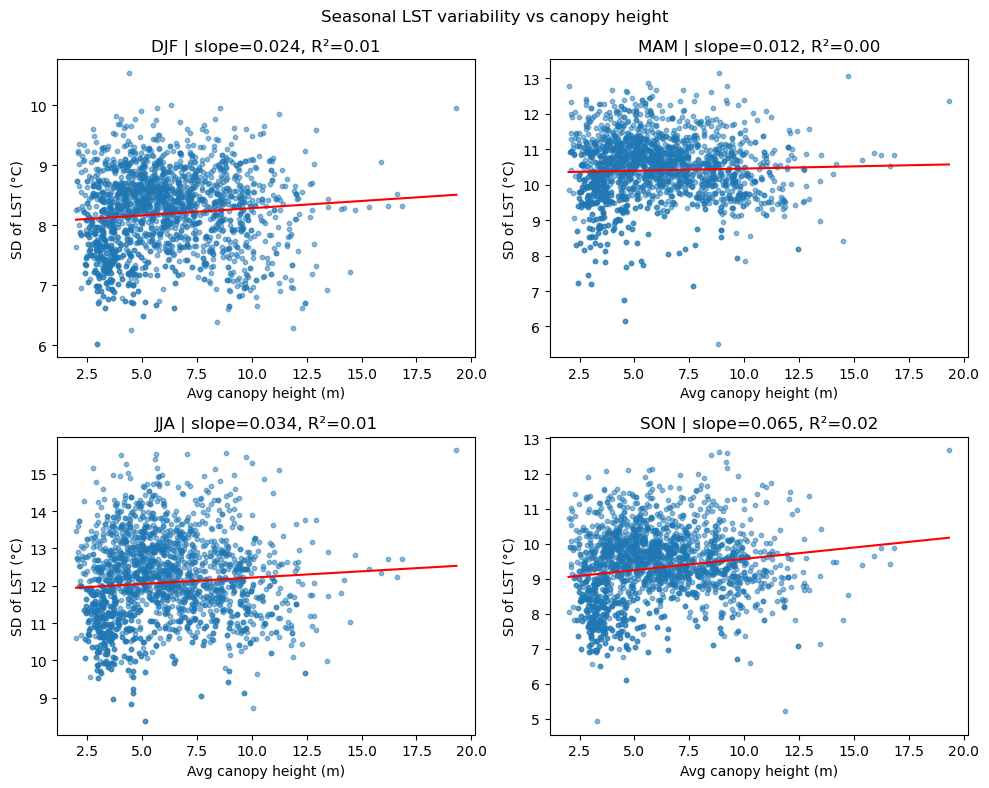

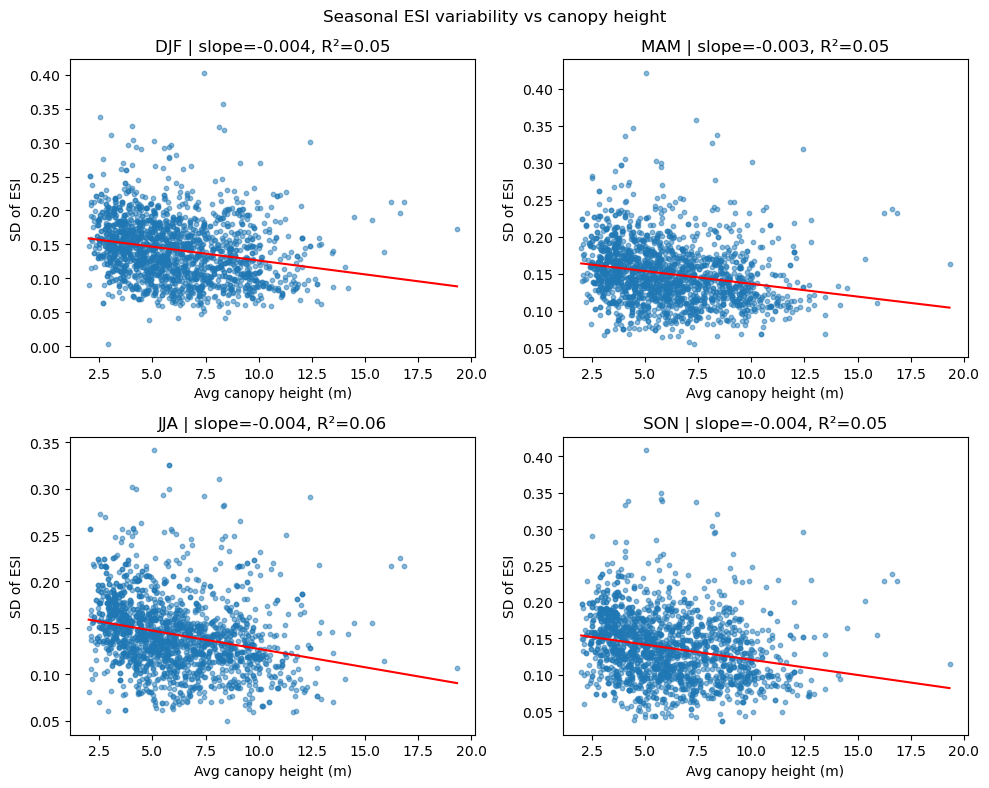

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

def plot_by_season(df, ycol, ylabel, title):
    seasons = ["DJF","MAM","JJA","SON"]
    plt.figure(figsize=(10,8))
    for i, season in enumerate(seasons,1):
        sub = df[df['season']==season]
        x = sub['avg_canopy_height_m']
        y = sub[ycol]
        mask = x.notna() & y.notna()
        slope, intercept, r_value, p_value, _ = linregress(x[mask], y[mask])

        plt.subplot(2,2,i)
        plt.scatter(x, y, s=10, alpha=0.5)
        xs = np.linspace(x.min(), x.max(), 100)
        plt.plot(xs, slope*xs+intercept, color="red")
        plt.title(f"{season} | slope={slope:.3f}, R²={r_value**2:.2f}")
        plt.xlabel("Avg canopy height (m)")
        plt.ylabel(ylabel)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Run for LST variability and ESI variability
plot_by_season(lst_season, "sd_meanC", "SD of LST (°C)", "Seasonal LST variability vs canopy height")
plot_by_season(esi_season, "sd_ESI", "SD of ESI", "Seasonal ESI variability vs canopy height")
